In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
import joblib
from IPython.display import Audio, display
import shutil
import matplotlib.pyplot as plt

In [2]:
def extract_audio_features(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)
    y = librosa.util.fix_length(y, size=5 * sr)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    pitch, mag = librosa.piptrack(y=y, sr=sr)
    pitches = pitch[mag > np.median(mag)]
    pitch_mean = np.mean(pitches) if len(pitches) > 0 else 0

    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    energy = np.mean(y ** 2)
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

    return {
        "mfcc": np.mean(mfcc, axis=1).tolist(),
        "pitch": float(pitch_mean),
        "energy": float(energy),
        "zcr": float(zcr),
        "centroid": float(centroid)
    }

In [3]:
def save_features_to_csv(folder_path, output_csv):
    data = []
    for file in glob(os.path.join(folder_path, "*.wav")):
        features = extract_audio_features(file)
        row = {
            "filename": os.path.basename(file),
            "pitch": features["pitch"],
            "energy": features["energy"],
            "zcr": features["zcr"],
            "centroid": features["centroid"]
        }
        for i, val in enumerate(features["mfcc"]):
            row[f"mfcc_{i+1}"] = val
        data.append(row)

    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"✅ Đã lưu đặc trưng vào {output_csv}")

    display(df.head(10))

    if len(df) > 0:
        feature_cols = [col for col in df.columns if col != "filename"]
        scaler = StandardScaler()
        df_scaled = df.copy()
        df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

        df_scaled.to_csv("voice_features_normalized.csv", index=False)
        joblib.dump(scaler, "scaler.pkl")

        print("✅ Đã chuẩn hóa và lưu voice_features_normalized.csv")
        print("✅ Đã lưu scaler.pkl")
    else:
        print("⚠️ Không có dữ liệu để chuẩn hóa.")

In [4]:
folder_path = "data"
output_csv = "voice_features.csv"

save_features_to_csv(folder_path, output_csv)


✅ Đã lưu đặc trưng vào voice_features.csv


,filename,pitch,energy,zcr,centroid,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,common_voice_vi_24574131.wav,1902.494507,0.000405,0.144472,1459.000791,-522.964722,54.904594,-12.703912,21.500427,-18.312178,-1.842497,-4.704542,-1.831501,-8.972088,0.080126,-8.504970,-0.093181,-6.853702
1,common_voice_vi_25258032.wav,1172.203003,0.006296,0.085682,973.042724,-429.320862,57.719776,5.120800,-7.192695,-6.269402,-0.722326,-4.684052,-2.523702,-6.837477,-5.681976,-2.994899,-9.301831,-7.821263
2,common_voice_vi_25226843.wav,1393.426636,0.003295,0.150092,1344.068019,-445.666992,41.390247,-4.375780,7.845428,5.136875,-7.414332,-9.499509,-4.640679,-2.435351,0.727367,-9.382046,2.650520,-4.500671
3,common_voice_vi_25223244.wav,1003.728088,0.002021,0.286811,1544.157301,-500.704376,29.864021,11.026809,14.485687,-9.194571,-7.052270,-7.247755,-5.606280,-10.201930,-4.283806,-8.304665,-1.460762,-1.778921
4,common_voice_vi_25223131.wav,914.951660,0.006504,0.313203,1786.226544,-422.248352,68.840614,12.111276,2.577155,-2.207580,-3.296420,-4.753026,-19.061199,-11.581624,-8.275156,-6.135947,-5.963434,-2.533113
5,common_voice_vi_24601510.wav,1867.565308,0.000178,0.166358,1791.320581,-518.685791,69.133881,-19.879553,21.981094,-19.603559,5.814898,-15.624944,-2.155530,-10.786522,-2.838197,-15.653818,-1.030383,-8.595779
6,common_voice_vi_23423355.wav,430.872589,0.001987,0.031427,664.537554,-478.156860,69.430496,15.745339,8.760016,4.631933,1.412203,-3.467169,-6.190527,-2.750938,-1.615876,-2.743089,-3.528254,-2.875460
7,common_voice_vi_24425741.wav,1088.031860,0.018734,0.075307,1065.842132,-225.493256,125.486038,-8.751800,24.699356,-20.790497,-3.567903,-7.418911,-8.656186,-13.193815,-7.861565,-18.098450,-12.111816,-9.068672
8,common_voice_vi_25226266.wav,1391.244751,0.006097,0.155936,1478.660502,-415.184723,61.334290,7.617727,7.275804,-3.908456,-6.871016,-1.581633,-0.576189,-7.848955,-3.692143,-4.518713,-0.757658,-6.084777
9,common_voice_vi_25224103.wav,591.265076,0.002092,0.314447,1397.762654,-554.114563,28.873522,0.292348,-1.829797,-0.327117,-0.584865,-4.215229,-0.746595,-3.830545,-1.026318,-2.907279,-1.075583,-0.473126


✅ Đã chuẩn hóa và lưu voice_features_normalized.csv
✅ Đã lưu scaler.pkl


In [5]:
def find_nearest_audio(input_audio, features_csv, scaler_path="scaler.pkl", top_k=3):
    features = extract_audio_features(input_audio)
    input_features = [features["pitch"], features["energy"], features["zcr"], features["centroid"]] + features["mfcc"]

    scaler = joblib.load(scaler_path)
    input_scaled = scaler.transform([input_features]) 

    df_features = pd.read_csv(features_csv)
    filenames = df_features["filename"].values
    feature_cols = [col for col in df_features.columns if col != "filename"]
    feature_vectors = df_features[feature_cols].values  

    distances = euclidean_distances(input_scaled, feature_vectors)[0]

    nearest_indices = np.argsort(distances)[:top_k]
    nearest_files = [(filenames[i], distances[i]) for i in nearest_indices]

    return nearest_files


In [8]:
input_audio_path = "input_sample.wav"

nearest = find_nearest_audio(input_audio_path, "voice_features_normalized.csv")

print("🔊 Input audio:")
display(Audio(input_audio_path))

print("\n🔍 3 file gần nhất:")
for filename, dist in nearest:
    print(f"📁 {filename} (distance: {dist:.4f})")
    display(Audio(os.path.join("output", filename)))




🔊 Input audio:


/Users/quocviet/Documents/BTL_HCSDLDPT/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔍 3 file gần nhất:
📁 common_voice_vi_23423355.wav (distance: 0.0000)


📁 common_voice_vi_23423374.wav (distance: 2.9779)


📁 common_voice_vi_22770199.wav (distance: 3.2233)


In [7]:
os.makedirs("output", exist_ok=True)

for i, (filename, dist) in enumerate(nearest):
    output_path = os.path.join("output", filename)
    input_path = os.path.join("data", filename)
    shutil.copy(input_path, output_path)
    print(f"Đã sao chép {filename} vào thư mục 'output'")


Đã sao chép common_voice_vi_23423355.wav vào thư mục 'output'
Đã sao chép common_voice_vi_23423374.wav vào thư mục 'output'
Đã sao chép common_voice_vi_22770199.wav vào thư mục 'output'


/Users/quocviet/Documents/dpt/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


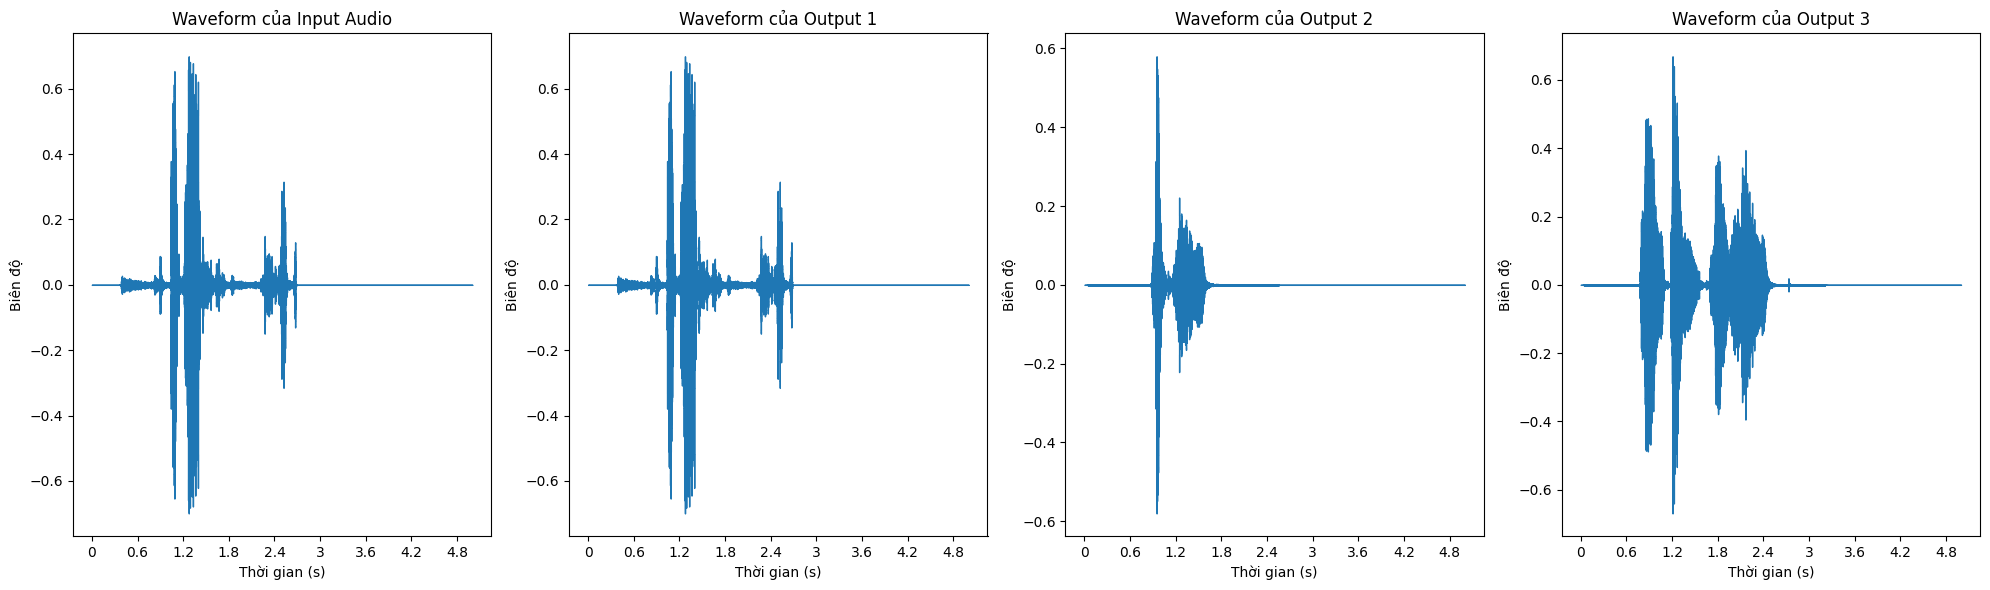

In [ ]:
import librosa.display

input_audio_path = "input_sample.wav"
y_input, sr_input = librosa.load(input_audio_path, sr=16000)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

librosa.display.waveshow(y_input, sr=sr_input, ax=axes[0])
axes[0].set_title("Waveform của Input Audio")
axes[0].set_xlabel("Thời gian (s)")
axes[0].set_ylabel("Biên độ")

nearest = find_nearest_audio(input_audio_path, "voice_features_normalized.csv")
output_files = [os.path.join("output", filename) for filename, _ in nearest]

for i, output_file in enumerate(output_files):
    y_output, sr_output = librosa.load(output_file, sr=16000)
    librosa.display.waveshow(y_output, sr=sr_output, ax=axes[i+1])
    axes[i+1].set_title(f"Waveform của Output {i+1}")
    axes[i+1].set_xlabel("Thời gian (s)")
    axes[i+1].set_ylabel("Biên độ")

plt.tight_layout()
plt.show()


/Users/quocviet/Documents/dpt/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


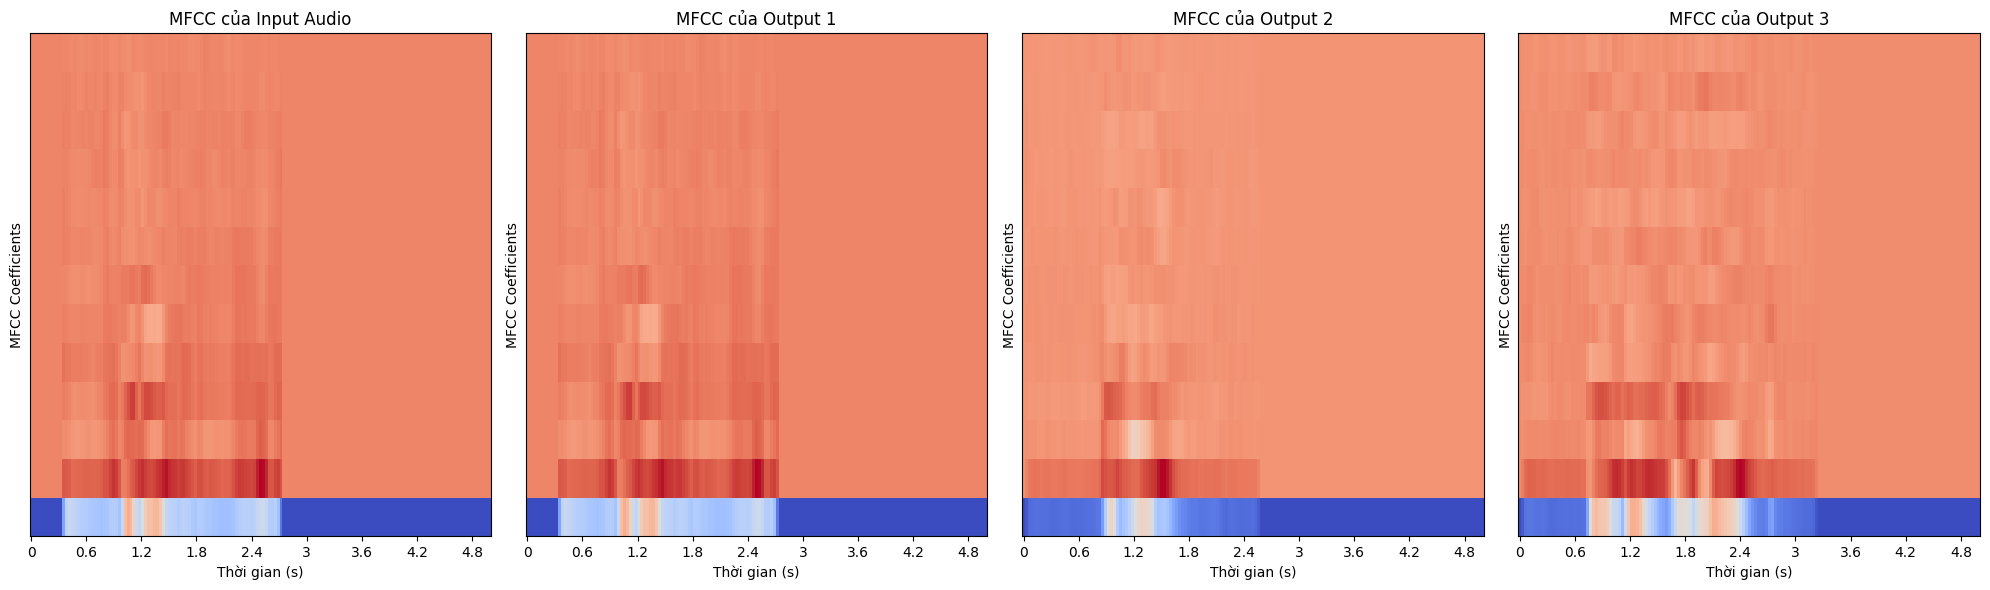

In [ ]:
import librosa.display

input_audio_path = "input_sample.wav"
y_input, sr_input = librosa.load(input_audio_path, sr=16000)

mfcc_input = librosa.feature.mfcc(y=y_input, sr=sr_input, n_mfcc=13)

nearest = find_nearest_audio(input_audio_path, "voice_features_normalized.csv")
output_files = [os.path.join("output", filename) for filename, _ in nearest]

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

librosa.display.specshow(mfcc_input, x_axis='time', sr=sr_input, ax=axes[0])
axes[0].set_title("MFCC của Input Audio")
axes[0].set_xlabel("Thời gian (s)")
axes[0].set_ylabel("MFCC Coefficients")

for i, output_file in enumerate(output_files):
    y_output, sr_output = librosa.load(output_file, sr=16000)
    mfcc_output = librosa.feature.mfcc(y=y_output, sr=sr_output, n_mfcc=13)
    
    librosa.display.specshow(mfcc_output, x_axis='time', sr=sr_output, ax=axes[i+1])
    axes[i+1].set_title(f"MFCC của Output {i+1}")
    axes[i+1].set_xlabel("Thời gian (s)")
    axes[i+1].set_ylabel("MFCC Coefficients")

plt.tight_layout()
plt.show()


/var/folders/78/thqydnt941qbhtbnwlf6mfph0000gn/T/ipykernel_36342/3961113257.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D_input = librosa.amplitude_to_db(librosa.stft(y_input), ref=np.max)
/Users/quocviet/Documents/dpt/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/78/thqydnt941qbhtbnwlf6mfph0000gn/T/ipykernel_36342/3961113257.py:20: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D_output = librosa.amplitude_to_db(librosa.stft(y_output), ref=np.max)


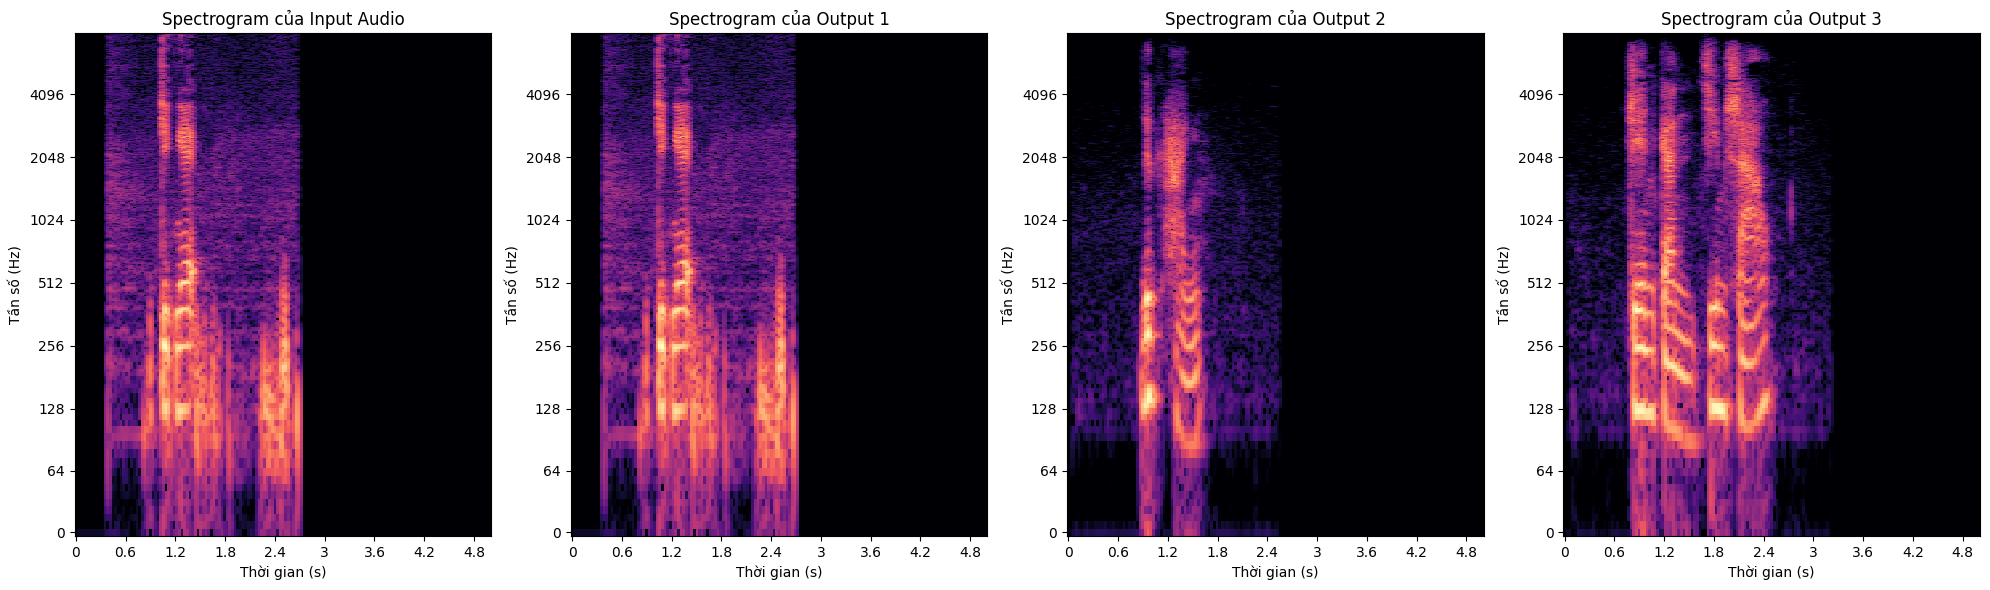

In [ ]:
import librosa.display

input_audio_path = "input_sample.wav"
y_input, sr_input = librosa.load(input_audio_path, sr=16000)

D_input = librosa.amplitude_to_db(librosa.stft(y_input), ref=np.max)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))

librosa.display.specshow(D_input, x_axis='time', y_axis='log', sr=sr_input, ax=axes[0])
axes[0].set_title("Spectrogram của Input Audio")
axes[0].set_xlabel("Thời gian (s)")
axes[0].set_ylabel("Tần số (Hz)")

nearest = find_nearest_audio(input_audio_path, "voice_features_normalized.csv")
output_files = [os.path.join("output", filename) for filename, _ in nearest]

for i, output_file in enumerate(output_files):
    y_output, sr_output = librosa.load(output_file, sr=16000)
    D_output = librosa.amplitude_to_db(librosa.stft(y_output), ref=np.max)
    
    librosa.display.specshow(D_output, x_axis='time', y_axis='log', sr=sr_output, ax=axes[i+1])
    axes[i+1].set_title(f"Spectrogram của Output {i+1}")
    axes[i+1].set_xlabel("Thời gian (s)")
    axes[i+1].set_ylabel("Tần số (Hz)")

plt.tight_layout()
plt.show()


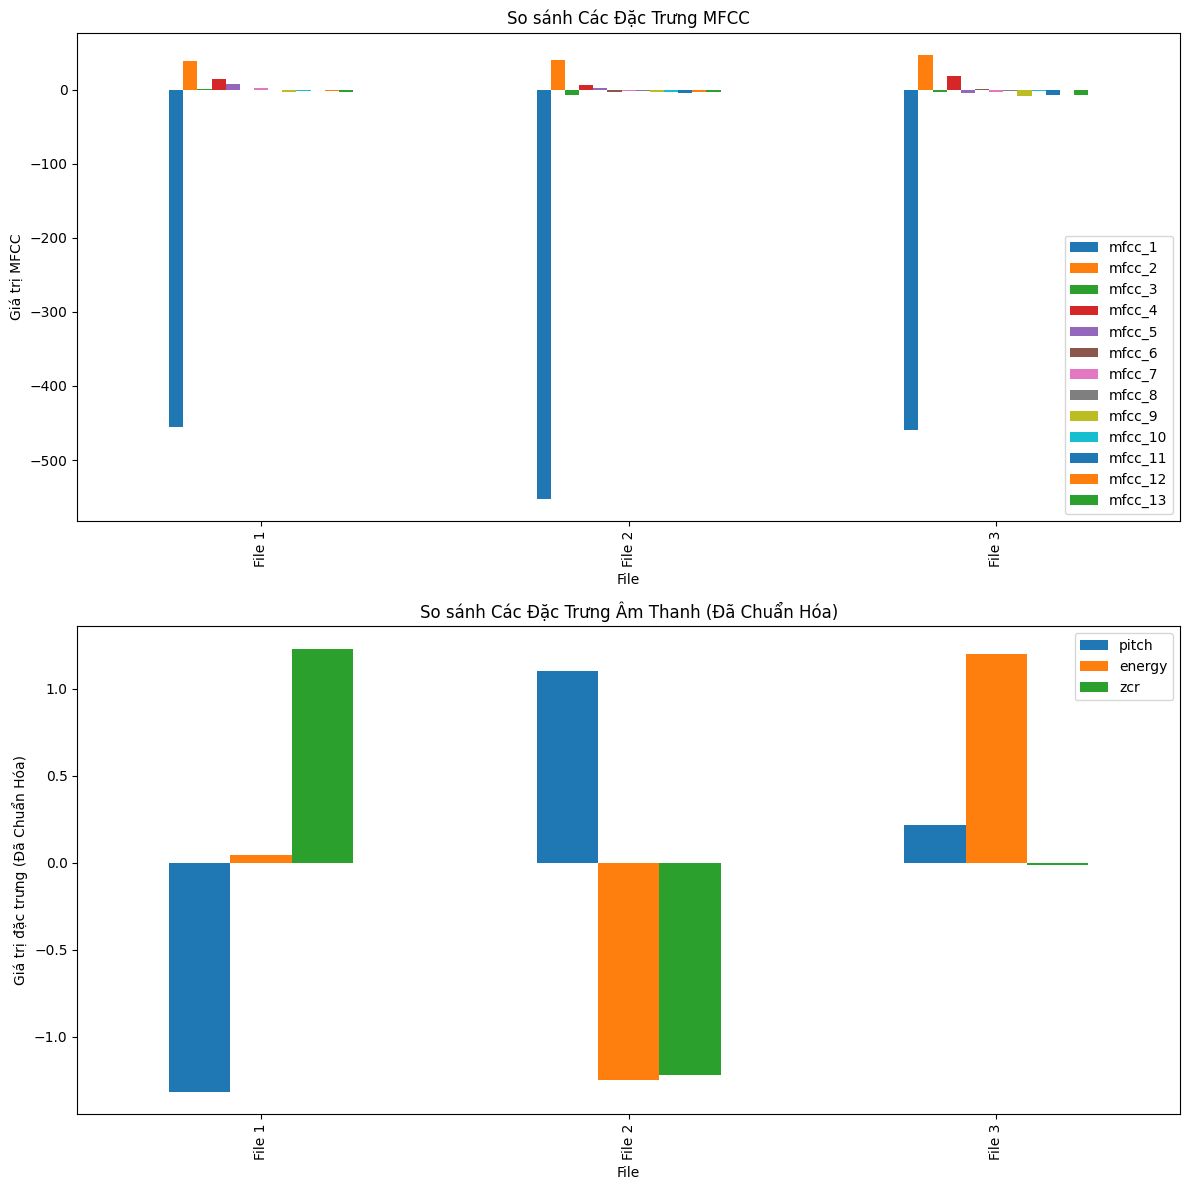

In [ ]:
files = [os.path.join("output", filename) for filename, _ in nearest]

features = []
mfcc_features = []  
for file in files:
    y, sr = librosa.load(file, sr=16000)
    
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    pitch = np.mean(librosa.piptrack(y=y, sr=sr)[0])
    energy = np.mean(y**2)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    
    features.append({
        "pitch": pitch,
        "energy": energy,
        "zcr": zcr
    })
    
    mfcc_features.append(mfcc)

df_features = pd.DataFrame(features, index=[f"File {i+1}" for i in range(3)])

scaler = StandardScaler()
df_features_scaled = df_features.copy()

feature_cols = ["pitch", "energy", "zcr"]
df_features_scaled[feature_cols] = scaler.fit_transform(df_features[feature_cols])

df_mfcc = pd.DataFrame(mfcc_features, columns=[f"mfcc_{i+1}" for i in range(13)], index=[f"File {i+1}" for i in range(3)])

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

df_mfcc.plot(kind='bar', ax=ax[0])
ax[0].set_title("So sánh Các Đặc Trưng MFCC")
ax[0].set_xlabel("File")
ax[0].set_ylabel("Giá trị MFCC")

df_features_scaled.plot(kind='bar', ax=ax[1])
ax[1].set_title("So sánh Các Đặc Trưng Âm Thanh (Đã Chuẩn Hóa)")
ax[1].set_xlabel("File")
ax[1].set_ylabel("Giá trị đặc trưng (Đã Chuẩn Hóa)")

plt.tight_layout()
plt.show()
